
# Car Doors Type Classification

## Part 1: Data Manipulation

### 1.1. Imports

In [1]:
# YOLO import
import sys
import pathlib
import os
import time
import copy
import cv2
import shutil
import matplotlib.pyplot as plt

sys.path.append(f"{pathlib.Path().absolute()}/YOLO")
import yolo

# must have imports
import pandas as pd
import numpy as np
from skimage import io, transform
from PIL import Image

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,models
from torchsummary import summary

# sklearn for metric
from sklearn.metrics import classification_report
from sklearn.metrics import auc,roc_curve,roc_auc_score
import tensorflow as tf

### 1.2. Constants

In [2]:
# Images Path
init_imgs_dir = 'data/img_data/car_imgs'
imgs_dir = 'result_data/images'

# CSV Path
csv_path = 'data/final.csv'
mod_csv_path = 'result_data/final.csv'

# Exterior/Interior strings
EXTERIOR = 'exterior'
INTERIOR = 'interior'

# Torch model's path
model_path = 'models/model_doors_type.pt'

### 1.3. Loading data from csv file

In [3]:
data = pd.read_csv(csv_path)
data = data[data.Doors.notna()]
data

,ID,Manufacturer,Model,Category,Mileage,Gear box type,Doors,Wheel,Color,Interior color,VIN,Leather interior,Price,Customs
1,45788844,TOYOTA,RAV 4,Jeep,30402 km,Variator,4/5,Left wheel,Blue,Black,NaN,0,15000,518.0
2,45653468,HONDA,Insight,Hatchback,210758 km,Automatic,4/5,Left wheel,Silver,NaN,JHMZE2H57AS029004,1,800,574.0
3,45731431,KIA,Optima,Sedan,131040 km,Tiptronic,4/5,Left wheel,White,Black,KNAGM4AD8D5052655,0,5500,751.0
4,45771182,LEXUS,ES 300,Sedan,135500 km,Tiptronic,4/5,Left wheel,White,Black,NaN,1,13500,NaN
5,45761498,TOYOTA,Prius,Hatchback,226000 km,Automatic,4/5,Left wheel,Blue,Beige,NaN,1,2980,761.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85932,40988107,MITSUBISHI,Pajero Sport,Jeep,0 km,Automatic,4/5,Left wheel,White,Black,NaN,1,31200,NaN
85933,43245646,JEEP,Wrangler rubicon unlimit,Jeep,0 km,Automatic,4/5,Left wheel,Grey,Black,NaN,0,Price,NaN
85934,39483245,JEEP,Grand Cherokee Laredo,Jeep,0 km,Automatic,4/5,Left wheel,Grey,Black,NaN,0,Price,NaN
85935,32774020,FIAT,500 Abarth,Hatchback,0 km,Automatic,2/3,Left wheel,White,Black,NaN,0,Price,NaN


### 1.4. Append image path to each record

If file is already created it will jump over this part

In [4]:
if not os.path.exists(mod_csv_path):
    # Create Empty Dataframe from old columns and plus image path
    old_columns = list(data.columns)
    mod_data = pd.DataFrame(columns=old_columns + ['img_path'])
    new_index = 0

    # Iterate over all cars and append record to given DF
    for index, row in data.iterrows():
        imgs_ext_dir = os.path.join(imgs_dir, str(row['ID']), EXTERIOR)
        # Check if path to exterior exists
        if not os.path.exists(imgs_ext_dir):
            continue
        for img_rel_path in os.listdir(imgs_ext_dir):
            img_abs_path = os.path.join(imgs_ext_dir, img_rel_path)
            # If image exists put into dataframe
            if os.path.exists(img_abs_path):   
                row['img_path'] = img_abs_path
                mod_data.loc[new_index] = row
                new_index +=1
        print(index, new_index)
    mod_data.to_csv(mod_csv_path)

In [5]:
data = pd.read_csv(mod_csv_path)
data

,Unnamed: 0,ID,Manufacturer,Model,Category,Mileage,Gear box type,Doors,Wheel,Color,Interior color,VIN,Leather interior,Price,Customs,img_path
0,0,45788844,TOYOTA,RAV 4,Jeep,30402 km,Variator,4/5,Left wheel,Blue,Black,NaN,0,15000,518.0,result_data/images/45788844/exterior/4.jpg
1,1,45788844,TOYOTA,RAV 4,Jeep,30402 km,Variator,4/5,Left wheel,Blue,Black,NaN,0,15000,518.0,result_data/images/45788844/exterior/1.jpg
2,2,45788844,TOYOTA,RAV 4,Jeep,30402 km,Variator,4/5,Left wheel,Blue,Black,NaN,0,15000,518.0,result_data/images/45788844/exterior/5.jpg
3,3,45653468,HONDA,Insight,Hatchback,210758 km,Automatic,4/5,Left wheel,Silver,NaN,JHMZE2H57AS029004,1,800,574.0,result_data/images/45653468/exterior/1.jpg
4,4,45653468,HONDA,Insight,Hatchback,210758 km,Automatic,4/5,Left wheel,Silver,NaN,JHMZE2H57AS029004,1,800,574.0,result_data/images/45653468/exterior/2.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323514,323514,32774020,FIAT,500 Abarth,Hatchback,0 km,Automatic,2/3,Left wheel,White,Black,NaN,0,Price,NaN,result_data/images/32774020/exterior/2.png
323515,323515,30709464,FIAT,500,Hatchback,0 km,Automatic,2/3,Left wheel,Sky blue,Grey,NaN,0,Price,NaN,result_data/images/30709464/exterior/1.png
323516,323516,30709464,FIAT,500,Hatchback,0 km,Automatic,2/3,Left wheel,Sky blue,Grey,NaN,0,Price,NaN,result_data/images/30709464/exterior/3.png
323517,323517,30709464,FIAT,500,Hatchback,0 km,Automatic,2/3,Left wheel,Sky blue,Grey,NaN,0,Price,NaN,result_data/images/30709464/exterior/0.png


### 1.5. View Available Door Types

In [6]:
door_types = data.Doors.unique()
door_types

array(['4/5', '2/3', '>5'], dtype=object)

As we can see there are 3 types of doors 

### 1.6 Data Revision

In [7]:
data.Doors.value_counts()

4/5    311677
2/3     10410
>5       1432
Name: Doors, dtype: int64

From this result we can see that data is awful... We need to change data so it is more acceptible for our model

##### 1.6.0 Declare constants for data extraction

In [8]:
TOTAL_DATA = 20000

_2DoorsCount = ('2/3', int(TOTAL_DATA * 0.7))
_4DoorsCount = ('4/5', int(TOTAL_DATA * 0.25))
_5DoorsCount = ('>5' , int(TOTAL_DATA * 0.05))

##### 1.6.1 Extract data of given size

In [9]:
_2DoorsData = data[data.Doors == _2DoorsCount[0]]
_4DoorsData = data[data.Doors == _4DoorsCount[0]]
_5DoorsData = data[data.Doors == _5DoorsCount[0]]

##### 1.6.2 Resample Data (Shuffle)

In [10]:
_2DoorsData = _2DoorsData.sample(frac=1)
_4DoorsData = _4DoorsData.sample(frac=1)
_5DoorsData = _5DoorsData.sample(frac=1)

##### 1.6.3 Extract data of given size

In [11]:
_2DoorsData = _2DoorsData[: _2DoorsCount[1]]
_4DoorsData = _4DoorsData[: _4DoorsCount[1]]
_5DoorsData = _5DoorsData[: _5DoorsCount[1]]

##### 1.6.4 Union Datas

In [12]:
mod_data = pd.concat([_2DoorsData, _4DoorsData, _5DoorsData])

##### 1.6.5 Review new data

In [13]:
mod_data.Doors.value_counts()

2/3    10410
4/5     5000
>5      1000
Name: Doors, dtype: int64

Now it seems to be normal distribution

### 1.7 Divide data into train, validation, test

In [14]:
# Propotions to be divided by
props = [int(.8*len(mod_data)), int(.9*len(mod_data))]

# Divide data into 3 parts
train, validate, test = np.split(mod_data.sample(frac=1), props)

## Part 2: PyTorch DataSet/DataLoader

### 2.1 Dataset

In [15]:
class CarsDataset(Dataset):
    """ Cars Dataframe Dataset """

    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.Dataframe): Dataframe object for data
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = df
        self.transform = transform
    
    def __len__(self):
         return len(self.df)

    def __getitem__(self, idx):
        sample = {'doors' : [-1],'image':[]}
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # Get Doors Type
        doors = np.where(door_types == self.df.iloc[idx].Doors)[0]
        
        # Get all images into array
        img_path = str(self.df.iloc[idx]['img_path'])
        if not os.path.exists(img_path):
            return sample
                       
        image = io.imread(img_path)
        
        # Data (Sample) to return
        sample = {'doors' : doors,'image': image}
        if self.transform:
            sample = self.transform(sample)
        return sample

### 2.2 Transform Clases

**Class Rescale**: Scales every picture to given size (by default its 256x256)

In [16]:
class Rescale(object):
    """ Rescale the image in a sample to a given size.

    Args:
        output_size (tuple): Desired output size. Output is matched to output_size. 
    """

    def __init__(self, output_size=(224, 224)):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, sample):
        """
        Args:
            sample(dict): {'doors' : doors,'images':images}
                    dictionary that represents doors type of car and array of images
        """
        # Get Image
        image = sample['image']
        
        # Rescale Image
        new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        image = transform.resize(image, (new_h, new_w))/255
        
        # Change Sample
        sample['image'] = image
        return sample

**Class ToTensor**: Changes all values to Tensors

In [17]:
class ToTensor(object):
    """ Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        """
        Args:
            sample(dict): {'doors' : doors,'images':images}
                    dictionary that represents doors type of car and array of images
        """

        # 1. Change (i, j, k) to (k, i, j)
        #        numpy image: H x W x C
        #        torch image: C X H X W
        sample['image'] = torch.Tensor(sample['image'].transpose((2, 0, 1)))
        
        # 2. change to tensor long
        sample['doors'] = torch.Tensor(sample['doors']).long()
        
        # return changed Sample
        return sample

### 2.3 Create Datasets with Transforms

In [18]:
# Create transforms array from Rescale class
_transforms = transforms.Compose([Rescale(), ToTensor()])

# Load Datasets
train_dataset = CarsDataset(train, transform=_transforms)
validate_dataset = CarsDataset(validate, transform=_transforms)
test_dataset = CarsDataset(test, transform=_transforms)

### 2.4 Create Dataloaders from Datasets

#### If torch.cuda.is_available(), we set device =”cuda”. This allows the program to be run on GPU or CPU based on the availability of GPU

We are setting num_workers as 1 and pin_memory as True in kwargs.num_workers denotes the number of processes that generate batches in parallel. Setting num_workers as a positive integer will turn on multi-process data loading with the specified number of loader worker processes. For data loading, passing pin_memory=True to a DataLoader will automatically put the fetched data Tensors in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.

In [19]:
BATCH_SIZE = 20
NUM_WORKERS = 8

device = "cuda" if torch.cuda.is_available() else "cpu"

loader_cfg = {'batch_size' : BATCH_SIZE,
              'shuffle' : True,
              'num_workers' : NUM_WORKERS,
              'pin_memory' : device == 'cuda'}

In [20]:
train_dataloader = DataLoader(train_dataset, **loader_cfg)
validate_dataloader = DataLoader(validate_dataset, **loader_cfg)
test_dataloader = DataLoader(test_dataset, **loader_cfg)

## Part 3: Model

In [21]:
class model_inc(nn.Module):
    def __init__(self):
        super(model_inc, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers.append(models.resnet18(pretrained=True))
        
        self.layers.append(nn.Linear(1000, 256))
        self.layers.append(nn.Dropout(0.1)) 
        
        self.layers.append(nn.Linear(256, 64))
        self.layers.append(nn.Dropout(0.1))
        
        self.layers.append(nn.Linear(64, len(data.Doors.unique())))
        self.layers.append(nn.Softmax(dim=1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [22]:
model = model_inc()
model.to(device)

summary(model, (3, 224, 224), batch_size=BATCH_SIZE, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [20, 64, 112, 112]           9,408
       BatchNorm2d-2         [20, 64, 112, 112]             128
              ReLU-3         [20, 64, 112, 112]               0
         MaxPool2d-4           [20, 64, 56, 56]               0
            Conv2d-5           [20, 64, 56, 56]          36,864
       BatchNorm2d-6           [20, 64, 56, 56]             128
              ReLU-7           [20, 64, 56, 56]               0
            Conv2d-8           [20, 64, 56, 56]          36,864
       BatchNorm2d-9           [20, 64, 56, 56]             128
             ReLU-10           [20, 64, 56, 56]               0
       BasicBlock-11           [20, 64, 56, 56]               0
           Conv2d-12           [20, 64, 56, 56]          36,864
      BatchNorm2d-13           [20, 64, 56, 56]             128
             ReLU-14           [20, 64,

# Part 4: Train-Validate-Test

### 4.0 Log Util Functions

In [23]:
LOG = True

class CLRS:
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    
def log(info):
    if LOG:
        print(info)

def log_loss(phase, loss, accuracy):
    log('{}: Loss: {:.3f} Accuracy: {:.3f}'.format(phase.ljust(10), loss, accuracy))    
    
def log_epoch_start(idx, total):
    log(CLRS.BOLD + 'Epoch {}/{}:'.format(idx + 1, total))
    log('=' * 40 + CLRS.ENDC)

def log_epoch_end(epoch):
    log('Epoch completed in {}m {}s'.format(int(epoch // 60), int(epoch % 60)))
    log('\n')
    
def log_result(time_elapsed, best_acc):
    log('Training completed in {}m {}s'.format(int(time_elapsed // 60), int(time_elapsed % 60)))
    log('Highest Accuracy: {:.3f}'.format(best_acc))
    
def log_test_result(time_elapsed, accuracy):
    log('Testing Completed in {}m {}s'.format(int(time_elapsed // 60), int(time_elapsed % 60)))
    log('Accuracy: {:.3f}'.format(accuracy))

### 4.1 Train

In [24]:
def train(model, loss_fn, optim_fn, scheduler, dataloader=train_dataloader):
    total_loss, total_accuracy = 0.0, 0

    # 0. Set Model for training mode
    model.train()  
    
    for sample in dataloader:
        # 1. Get Image from sample as input and doors type as label
        inputs, labels = sample['image'], sample['doors']
        # 2. Send Tensors to given device
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.reshape((labels.shape[0]))
        
        
        # ADD zero the parameter gradients
        optim_fn.zero_grad()
        
        # 3. Set Gradient Calculation ON
        #    We are in training phase and we need to backpropagate for current computations
        with torch.set_grad_enabled(True):
            # 3.1 Get output with current model
            outputs = model(inputs) # Model outputs array with corresponding probabilities
            preds = torch.argmax(outputs, 1) # Picks one with highest
            loss = loss_fn(outputs, labels.reshape((-1,)))

            # 3.2 Backward Propagation
            loss.backward()
            optim_fn.step()

        # 4. Evaluate Statistics for current model (loss, accuracy)
        total_loss += loss.item() * inputs.size(0)
        total_accuracy += torch.sum(preds == labels.data)

    # 5. Optimize
    scheduler.step()
    
    # 6. Log current results
    total_loss = total_loss / len(dataloader.dataset)
    total_accuracy = total_accuracy.double() / len(dataloader.dataset)
    log_loss('Train', total_loss, total_accuracy)

### 4.2 Validate

In [25]:
def validate(model, loss_fn, optim_fn, scheduler, dataloader=validate_dataloader):
    total_loss, total_accuracy = 0.0, 0

    # 0. Set Model for evaluation mode
    model.eval()

    for sample in dataloader:
        # 1. Get Image from sample as input and doors type as label (Tensors)
        inputs, labels = sample['image'], sample['doors']
        # 2. Send Tensors to given device
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.reshape((labels.shape[0]))
            
        # 3. Set Gradient Calculation OFF
        #    We are in validating phase and we dont wish to backpropagate for current computations
        
        # ADD zero the parameter gradients
        optim_fn.zero_grad()

        with torch.set_grad_enabled(False):
            outputs = model(inputs) # Model outputs array with corresponding probabilities
            preds = torch.argmax(outputs, 1) # Picks one with highest
            loss = loss_fn(outputs, labels.reshape((-1,))) # Evaluate loss 

        # 4. Evaluate Statistics for current model (loss, accuracy)
        total_loss += (loss.item() * inputs.size(0))
        total_accuracy += (torch.sum(preds == labels.data))

    # 5. Log current results
    total_loss = total_loss / len(dataloader.dataset)
    total_accuracy = total_accuracy.double() / len(dataloader.dataset)
    log_loss('Validation', total_loss, total_accuracy)    

    # return result
    return (total_accuracy, copy.deepcopy(model.state_dict()))

### 4.3 Test

In [26]:
def test(model, dataloader=test_dataloader):
    start_time = time.time()
    total_accuracy = 0
    for sample in dataloader:
        # 1. Get Image from sample as input and doors type as label (Tensors)
        inputs, labels = sample['image'], sample['doors']
        # 2. Send Tensors to given device
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.reshape((labels.shape[0]))
        # 3. Get model prediction
        outputs = model(inputs) # Model outputs array with corresponding probabilities
        preds = torch.argmax(outputs, 1) # Picks one with highest
        
        # 4. Count true predictions
        total_accuracy += (torch.sum(preds == labels.data))
    total_accuracy = total_accuracy.double() / len(dataloader.dataset)
    end_time = time.time()
    log_test_result(end_time-start_time, total_accuracy)    

# part 5: Model Training

In [27]:
def train_model(model, loss_fn, optim_fn, scheduler, num_epochs=25):
    # Initilize with starting values
    start_time = time.time()
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    # Iterate for num_epochs time
    for epoch in range(num_epochs):
        epoch_start = time.time()
        log_epoch_start(epoch, num_epochs) 
        
        # Train -> Validate -> Check for improvements
        train(model, loss_fn, optim_fn, scheduler)
        res_acc, res_weights = validate(model, loss_fn, optim_fn, scheduler)
        if res_acc > best_acc:
            best_acc, best_weights = res_acc, res_weights
        
        epoch_end = time.time()
        log_epoch_end(epoch_end-epoch_start)
        
    # Log final result
    time_elapsed = time.time() - start_time
    log_result(time_elapsed, best_acc)
    
    # load best model weights and return trained model
    model.load_state_dict(best_weights)
    return model

### 5.1 Create Model Parameters/Functions

#### Model Parameters

In [28]:
# Used for optimizer function
LR = 0.002
MOMENTUM = 0.9

# Used for schedulre function
STEP_SIZE = 5
GAMMA = 0.1

# Used for training function
EPOCHS = 5

#### Loss, Optimze, Schedule functions

In [29]:
# Combination of nn.LogSoftmax() and nn.NLLLoss() in one single class.
loss_fn = nn.CrossEntropyLoss()

# Stochastic Gradient Descent with momentum
optim_fn = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

# Decays the learning rate of each parameter group by 0.1 every 7 epochs.
scheduler = lr_scheduler.StepLR(optim_fn, step_size=STEP_SIZE, gamma=GAMMA)

### 5.2 Train/Validate Phase

In [30]:
if os.path.exists(model_path):
    weights = torch.load(model_path)
    model.load_state_dict(weights)
    model.eval()
else:
    model = train_model(model, loss_fn, optim_fn, scheduler, num_epochs=EPOCHS)
    torch.save(model.state_dict(), model_path)

### 5.3 Test Phase

In [31]:
test(model)

Testing Completed in 1m 13s
Accuracy: 0.841


# Part 6: Real Life Test

## This is part where we take ID as an input and try to determine whether our model gives correct guess.

### Util Functions

### 6.1 Create YOLO Model

In [32]:
%%capture
# YOLO() dumps data to stdout, %%caputer will prevent printing

# Model Initialization
os.chdir('YOLO')
YOLO_model = yolo.YOLO_np()
os.chdir('..')

# Save Temporary pictures
TMP = 'tmp'
if os.path.exists(TMP):
    shutil.rmtree(TMP)
os.mkdir(TMP)

# Model Prediction returns classes for which number 2 stands for car
ENUM_CAR_CLASS = 2

# Model return rectangle coordinates, that represents area, where object is located
# We use this constant to determine if this area is small enough to be ignored
ERROR_DEVIATION = 0.2

CLASS_WEIGHTS = {'4/5' : 1, '2/3' : 0.8, '>5':1}

### 6.2 get_images() return all images paths

In [33]:
def get_images(ID):
    car_path = os.path.join(init_imgs_dir, ID)
    images = []
    for img_path in os.listdir(car_path):
        try:
            img_abs_path = os.path.join(car_path, img_path)
            image = Image.open(img_abs_path)
            images.append(img_abs_path)
        except:
            pass
    return images

### 6.3 detect_car() detects if car is on image

In [34]:
def detect_car(path, model=YOLO_model):
    # 1. Open Image
    image = Image.open(path)
    
    # 2. Preprocessing 
    image_data = yolo.preprocess_image(image, model.model_image_size)
    #origin image shape, in (height, width) format
    image_shape = tuple(reversed(image.size))


    # 3. Prediction
    boxes, classes, scores = model.predict(image_data, image_shape)
    
    # 4. Check if car is in the detected objects
    for i in range(len(classes)):
        if classes[i] == ENUM_CAR_CLASS:
            # 4.1. If car is detected check for box area
            box = boxes[i]
            area = abs((box[2] - box[0]) * (box[3] - box[1]))
            
            # 4.2. Normalize evaluated area
            area = area/(image_shape[0]*image_shape[1])

            # 4.3. If box area is too small, we can ignore it
            if area > ERROR_DEVIATION:
                return True, box
    return False, None

### 6.4 crop_image() crops image with given coordinates

In [35]:
def crop_image(src_path, dst_path, coordinates=None):
    img = cv2.imread(src_path)

    # Sanity Check for boxes to be in the given image shape
    img_height, img_width, _ =img.shape 

    if coordinates is not None:
        coordinates[0] = min(img_width - 1, max(0, coordinates[0]))
        coordinates[2] = min(img_width - 1, max(0, coordinates[2]))

        coordinates[1] = min(img_height- 1, max(0, coordinates[1]))
        coordinates[3] = min(img_height- 1, max(0, coordinates[3]))

        crop_img = img[coordinates[1]:coordinates[3],
                       coordinates[0]:coordinates[2]]
        img = crop_img
    
    # Using cv2.imwrite() method 
    # Saving the image 
    cv2.imwrite(dst_path, img)

### 6.5 determine_door_type() return array representing prediction for each class

In [36]:
def _process_image(image_path):
    # Preview Exterior images
    image = io.imread(image_path)
    if LOG:
        plt.figure()
        plt.imshow(image)
    
    # Rescale Image
    prop = image.shape[1]/image.shape[0]
    new_h, new_w = (224,224)
    new_h, new_w = int(new_h), int(new_w)
    image = transform.resize(image, (new_h, new_w))/255
    
    # Convert to tensor
    image = torch.Tensor(image.transpose((2, 0, 1)))
    
    return image, prop

def determine_door_type(images):
    res = []
    for image_path in images:
        inputs, prop = _process_image(image_path)
        
        inputs = inputs.unsqueeze(0)
        outputs = model(inputs) # Model outputs array with corresponding probabilities
        res += [outputs * prop]
    
    res = sum(res).tolist()[0]
    res = [float(x)/sum(res) for x in res]
    res = [x*CLASS_WEIGHTS[door_types[i]] for i, x in enumerate(res)]
    res = [int(x*100)/100 for x in res]
    log("Findal result for each door types are:")
    log(res)
    
    return res # Picks one with highest

### 6.6 argmax() returns index of max value

In [37]:
def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

### 6.7 detect_doors() Wrapper function that takes one input ID and returns predictions

In [38]:
def detect_doors(ID):
    # 1. Get All Image paths of given ID   
    images = get_images(ID)
    log("Total Images: {}".format(len(images)))
    
    # 2. Extract only exterior images
    ext_images = []
    for idx, image in enumerate(images):
        result, coordinates = detect_car(image, YOLO_model)
        # if picture is interior we can skip it
        if not result:
            continue
            
        # 3. Crop car parts from picture
        tmp_path = os.path.join(TMP, os.path.basename(image))
        crop_image(image, tmp_path, coordinates)
        ext_images += [tmp_path]
    log("Total Exterior Images: {}".format(len(ext_images)))
    
    # 4. Now all files are in TMP folder
    res = determine_door_type(ext_images)
    
    return res

Total Images: 10
Total Exterior Images: 5
Findal result for each door types are:
[0.99, 0.0, 0.0]
Prediction: Door Type 4/5


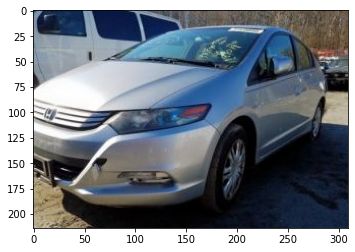

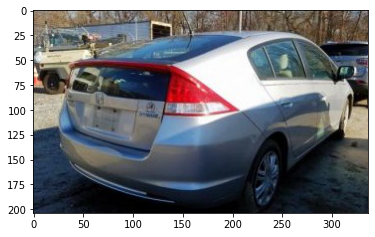

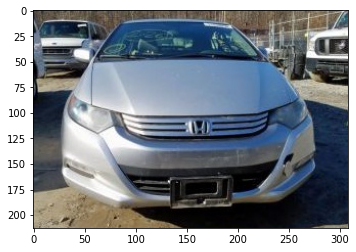

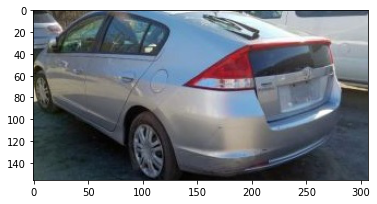

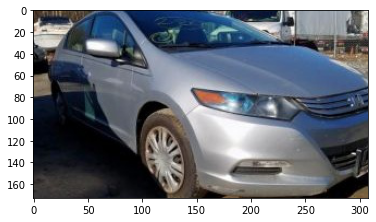

In [39]:
ID = '45653468'
result = detect_doors(ID)

ind = argmax(result)
print("Prediction: Door Type {}".format(door_types[ind]))

Total Images: 6
Total Exterior Images: 5
Findal result for each door types are:
[0.0, 0.79, 0.0]
Prediction: Door Type 2/3


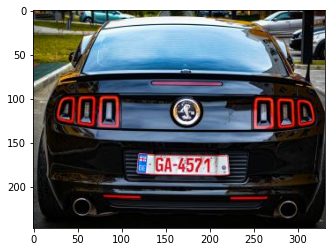

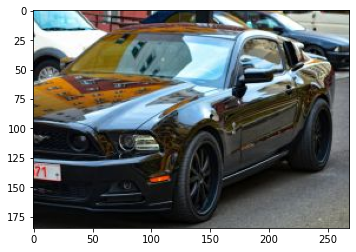

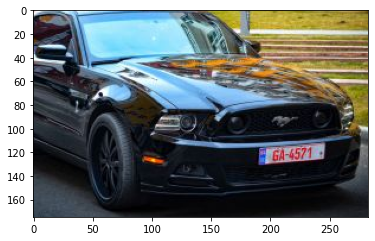

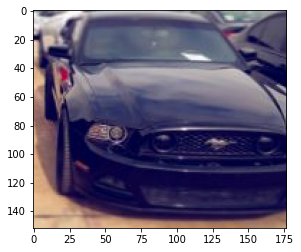

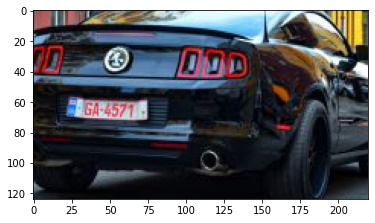

In [40]:
ID = '45668032'
result = detect_doors(ID)

ind = argmax(result)
print("Prediction: Door Type {}".format(door_types[ind]))

### 6.8 Detect and check result on multiple data

In [41]:
check_size = 200
correct_count = 0

checker_data = data.sample(frac=1)[:check_size]
LOG = False

In [42]:
start_time = time.time()

y_pred = []
y_true = []
for idx, row in checker_data.iterrows():
    # Get info from Dataframe
    ID = str(row['ID'])
    doors = row['Doors']
    
    # Get result from Model
    result = detect_doors(ID)
    ind = argmax(result)
    
    # Compare
    pred_type = door_types[ind]
    if pred_type == doors:
        correct_count += 1
        
    
    y_pred.append(pred_type)
    y_true.append(doors)
end_time = time.time()
elapsed = end_time-start_time

In [43]:
print("Elapsed Time    : {}m {}s".format(int(elapsed//60), int(elapsed%60)))
print("Total ID Passed : {}\n".format(check_size))

print(classification_report(y_true, y_pred, target_names=door_types, labels=door_types, zero_division=1))

Elapsed Time    : 4m 37s
Total ID Passed : 200

              precision    recall  f1-score   support

         4/5       0.99      0.95      0.97       192
         2/3       0.41      0.88      0.56         8
          >5       1.00      1.00      1.00         0

   micro avg       0.94      0.94      0.94       200
   macro avg       0.80      0.94      0.84       200
weighted avg       0.97      0.94      0.95       200

